
### Import libraries and modules

In [209]:
import copy
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions import create_inputsTable_UTOPIA
from functions.create_rateConstants_tabel import *
from functions.fillInteractions_df_fun import *
from functions.generate_modelObjects import *
from functions.generateRateConstants_particles import *
from functions.solver_SteadyState import *
from functions.extract_results import *
from functions.plot_results import *
from functions.massBalance import *
from functions.exposure_indicators_calculation import *
from functions.generate_MPinputs_table import *
from functions.save_results import *
from functions.loop_CTD_calculation import *
from functions.generate_compartmentFlows_tables import *
from functions.emission_fractions_calculation import *
from helpers.helpers import *

Set up path for inputs folder

In [210]:
##Set current working directory
cwd=os.getcwd()
inputs_path = cwd+"\inputs"

### Define run parameters

#### Define microplastics physical properties

In [211]:
MPdensity_kg_m3 = 980
MP_composition = "PE"
shape = "sphere"  # Fixed for now
N_sizeBins = 5  # Fixed, should not be changed. The 5 size bins are generated as being one order of magnitude appart and cover the range from mm to nm(i.e. 5000um, 500um, 50um, 5um, 0.5um)
big_bin_diameter_um = 5000  # This size can not be bigger than 10 mm (10000um) or smaller than 1 mm(1000um)
runName = MP_composition

MP_inputs={"MP_composition":MP_composition,"shape":shape,"N_sizeBins":N_sizeBins,"big_bin_diameter_um":big_bin_diameter_um,"runName":runName,"inputs_path":inputs_path}


In [212]:
# write microplastics inputs file
mp_imputFile_name = write_MPinputs_table(
    MPdensity_kg_m3,
    MP_composition,
    shape,
    N_sizeBins,
    big_bin_diameter_um,
    runName,
    inputs_path,
)

#### Define Environmental Characteristics

##### Suspended particulates properties

In [213]:
# From Kooi et al. (2017)
v_a = 2.0e-16  # Volume of 1 algal cell [m-3]
r_a = ((3.0 / 4.0) * (v_a / math.pi)) ** (1.0 / 3.0)  # radius of algae [m]

spm_radius_um = r_a * 1e6
spm_density_kg_m3 = 1388  # REF: Kooi et al. (2017)

##### Compartment properties

In [214]:
comp_impFile_name = "\inputs_compartments.csv"  # Preloaded values, the user should be able to create its own inputs_compartments.csv file (via donwloading the file and typing news values without chaing the structure of the file) when a new file wants to be used the name should be changed here
comp_interactFile_name = (
    "\compartment_interactions.csv"  # Fixed, should not be modified
)

##### Generate model objects (via reading selected input files)

In [215]:
# Generate objects
boxName = "Utopia"  # fixed, do not modify

(
    system_particle_object_list,
    SpeciesList,
    spm,
    dict_comp,
    model_lists,
    particles_df,
) = generate_objects(
    inputs_path,
    boxName=boxName,
    MPforms_list=MPforms_list,
    comp_impFile_name=comp_impFile_name,
    comp_interactFile_name=comp_interactFile_name,
    mp_imputFile_name=mp_imputFile_name,
    spm_radius_um=spm_radius_um,
    spm_density_kg_m3=spm_density_kg_m3,
)


surfComp_list = [c for c in dict_comp if "Surface" in c]

#### Define Microplastics weathering properties


##### Select fragmentation style
In out approach each particle fractions into fragments of smaller sizes and the distribution is expresses via a fragment size distribution matrix (fsd), as descibed in https://microplastics-cluster.github.io/fragment-mnp/advanced-usage/fragment-size-distribution.html .  

In this matrix the smallest size fraction is in the first possition and we consider no fragmentation for this size class 

Below we define 4 different styles of fragmentation via defining the fsd for each of them. The user can choose form one of the proposed fragmentation styles or define its own fsd by including it in the frag_styles_dict following the structure below.

We provide a slider (to be done) where the user can select a fragmentation style by means of choosing a value of FI (fragmentation index) between 0 and 1 that describe two scenarios :

- Erosive fragmentation (FI=0): In this scenario the particles are being eroded on their surface and therefore most of their mass remain in their same size fraction and samall fraction in going to the samllest size bins. Its representative fsd is: 
  
    [[0, 0, 0, 0, 0],

    [1, 0, 0, 0, 0],

    [0.99, 0.01, 0, 0, 0],

    [0.999, 0, 0.001, 0, 0],
    
    [0.9999, 0, 0, 0.0001, 0],]

- Sequential fragmentation (FI=1): in this scenario each size fraction breacks down completely into the next smallest size bin.
Its representative fsd is: 

    [[0, 0, 0, 0, 0],

    [1, 0, 0, 0, 0],

    [0, 1, 0, 0, 0],

    [0, 0, 1, 0, 0],
    
    [0, 0, 0, 1, 0],]

By choosing a value between 0 and 1 the user can select a fragmentation style in between both extremes.

In [216]:
## Select a value for FI in the range 0-1 where:
frag_styles_dict = {0:"erosive_fragmentation",0.5:"mixed_fragmentation",1:"sequential_fragmentation"} ## Slider??
FI = 0.5  # from slider or user imput

# Generate the fsd matrix
fsd = generate_fsd_matrix(FI)
# Create a dataframe from the fsd matrix
sizes = [list(model_lists["dict_size_coding"].keys())]
fsd_df = pd.DataFrame(fsd, index=sizes, columns=sizes)

# Save the fsd matrix (not sure if we need to save it-- to be revisited)
fsd_filename = os.path.join(inputs_path, "fsd.csv")
fsd_df.to_csv(fsd_filename)

# Verify the sum of each row
row_sums = fsd.sum(axis=1)
print("\nSum of each row:")
for idx, sum_value in enumerate(row_sums):
    print(f"Row {idx + 1}: {sum_value}")


Sum of each row:
Row 1: 0.0
Row 2: 1.0
Row 3: 1.0
Row 4: 1.0
Row 5: 1.0


In [217]:
frag_style = frag_styles_dict[FI]
frag_style ### We need this now for the save fiction but should be substituted for FI=x? so that we can choose any value in the range 0-1

'mixed_fragmentation'

##### Define Weathering processes input parameters

##### Degradation half time: thalf_deg_d

The model provides a default value for degradation time of Free MPs taken from Domercq et al. 2021 in the file (t_half_deg_free.csv):

The assumptions made for the definition of these degradation times: (NEW assumptions)

- Heteroaggregated particles degrade 10 times slower than the free MPs

- Biofouled particles degrade 2 times faster than the free MPs

- Both degradation and fragmentation rates are compartment dependent: we assume that in the 
  
  - surface water compartments both degradation and fragmentation are fastest
  - in soil surface and deeper water compartments both rates are 10 times slower (factor_deepWater_soilSurface)
  - in sediments and deeper soil compartments they both are 100 times slower (factor_sediment)

If the user want to provide its own values of thalf_deg_d the values can be modified in the following cells

In [218]:
t_half_deg_free = 66000 # in days (10 times slower than the rate of degradation (to form dissolved organics) shown in Pfohl et al. 2023 for TPU-arom)
heter_deg_factor = 10
biof_deg_factor = 1 / 2

In [219]:
t_half_deg_heter = t_half_deg_free * heter_deg_factor
t_half_deg_biof = t_half_deg_free * biof_deg_factor
t_half_deg_biofHeter = t_half_deg_free * biof_deg_factor * heter_deg_factor

In [220]:
factor_deepWater_soilSurface = 10
factor_sediment = 100

In [221]:
thalf_deg_d_dict = {
    "freeMP": t_half_deg_free,
    "heterMP": t_half_deg_heter,
    "biofMP": t_half_deg_biof,
    "heterBiofMP": t_half_deg_biofHeter,
} 

print(thalf_deg_d_dict)


{'freeMP': 66000, 'heterMP': 660000, 'biofMP': 33000.0, 'heterBiofMP': 330000.0}


#### Heteroaggregation attachment efficiency: alpha_heter.

In [222]:
alpha_heter_filename = os.path.join(inputs_path, "alpha_heter.csv")
alpha_heter_df = pd.read_csv(alpha_heter_filename)
alpha_hetr_dict = alpha_heter_df.set_index("MP_form")["alpha_heter"].to_dict()

In [223]:
alpha_hetr_dict

{'freeMP': '0.01', 'heterMP': 'NAN', 'biofMP': '0.02', 'heterBiofMP': 'NAN'}

#### Timescales of fragmentation

The fragmentation timescales are deteremined from the stablished fragmentation half time of 36.5 days for the biggest size fraction in free form in the surface water compartments following the parameters chosen in Domercq et al. 2021.

In UTOPIA we include the following assumptions for fragmentation:

-heteroaggregated MPs fragmnet 100 slower than fragmentation of the Free MPs 
-biofouled and heteroaggregated will be two times slowed of those only heteroaggregated, following the same assumption as for free and biofouled. 

These values are used in the Domercq et al. 2021 paper and they are asumptions made from lack of current knowlegde

In [224]:
#t_frag_gen_FreeSurfaceWater = 248000  # in days derived from Pfohl et al. 2022 for TPU particles
t_frag_gen_FreeSurfaceWater = 36.5  # in days
biof_frag_factor = 2
heter_frag_factor = 100

#In the surface beach compratment the fragmentation is enhanced or the same as in surface water layers (to be included in the assumptions)

In [225]:
process_inputs_df = create_inputsTable_UTOPIA(
    inputs_path,
    model_lists,
    thalf_deg_d_dict,
    alpha_hetr_dict,
    t_frag_gen_FreeSurfaceWater,
    biof_frag_factor,
    heter_frag_factor,
    factor_deepWater_soilSurface,
    factor_sediment,
    save_op="save",
)

#### Define emission scenario

Choose input flow (in g per second) and define in wich form and size the particles are released into the environment and specify the input flow for each compartment

In [226]:
# Size fraction:
# for the preloaded scenario:
# a= 0.5 um = mp1
# b= 5 um = mp2
# c= 50 um = mp3
# d= 500 um = mp4
# e= 5000 um = mp5
import string

size_codes = [letter for letter in string.ascii_lowercase[0:N_sizeBins]]
size_dict = dict(zip(size_codes, model_lists["dict_size_coding"].values()))

# Aggregation state (MP form):
# A= Free MP
# B= heteroaggregatedMP
# C= biofouled MP
# D= biofouled and heteroaggregated MP
MPforms_list = ["freeMP", "heterMP", "biofMP", "heterBiofMP"]
particle_forms_coding = dict(zip(MPforms_list, ["A", "B", "C", "D"]))
MP_form_dict_reverse = {v: k for k, v in particle_forms_coding.items()}

##### Select size bin and form

In [227]:
size_bin = "e"  # Chosse from size_dict
MP_form = "freeMP"  # Choose from MPforms_list above

##### Type input flow in g/s

If inputs are only made to one compartment:

In [228]:
emiss_comp = "Coast_Surface_Water"  # Select compartment from the compartment list
input_flow_g_s = 104642 # Choose input flow (in g per second) REF: fraction of microplastics from estimated 8Mt per year plastic released into the ocean Sonke et al. Microplastics and Nanoplastics (2022)


Based on estimates by the Global plastics budget and cycle for the year 2015 based on best-available observations and model estimates. (REF: Sonke et al. Microplastics and Nanoplastics (2022) 2:28 https://doi.org/10.1186/s43591-022-00048-w)
Emissions from rivers into the oceans: 3.3 Tg (10^12g) per year: 104642g/sec


In [229]:


q_mass_g_s_dict = {
    "Ocean_Surface_Water": 0,
    "Ocean_Mixed_Water": 0,
    "Ocean_Column_Water": 0,
    "Coast_Surface_Water": 0,
    "Coast_Column_Water": 0,
    "Surface_Freshwater": 0,
    "Bulk_Freshwater": 0,
    "Sediment_Freshwater": 0,
    "Sediment_Ocean": 0,
    "Sediment_Coast": 0,
    "Beaches_Soil_Surface": 0,
    "Beaches_Deep_Soil": 0,
    "Background_Soil_Surface": 0,
    "Background_Soil": 0,
    "Impacted_Soil_Surface": 0,
    "Impacted_Soil": 0,
    "Air": 0,
}

q_mass_g_s_dict[emiss_comp] = input_flow_g_s

If emissions are made to several compartments type the input flows corresponding to the specific compartments in the following dictionary:

q_mass_g_s_dict = {
    "Ocean_Surface_Water": 0,
    "Ocean_Mixed_Water": 0,
    "Ocean_Column_Water": 0,
    "Coast_Surface_Water": 0,
    "Coast_Column_Water": 0,
    "Surface_Freshwater": 0,
    "Bulk_Freshwater": 0,
    "Sediment_Freshwater": 0,
    "Sediment_Ocean": 0,
    "Sediment_Coast": 0,
    "Urban_Soil_Surface": 0,
    "Urban_Soil": 0,
    "Background_Soil_Surface": 0,
    "Background_Soil": 0,
    "Agricultural_Soil_Surface": 0,
    "Agricultural_Soil": 0,
    "Air": 0,
}

If inputs are made to different size classess and MP forms the following dictionary has to be used:


In [230]:
input_flow_filename = os.path.join(inputs_path, "inputFlows.csv")
input_flows_df = pd.DataFrame(
    list(q_mass_g_s_dict.items()), columns=["compartment", "q_mass_g_s"]
)
input_flows_df.to_csv(input_flow_filename, index=False)

In [231]:
# Generate dict of emission flows
particle_compartmentCoding = dict(
    zip(
        model_lists["compartmentNames_list"],
        list(range(len(model_lists["compartmentNames_list"]))),
    )
)
comp_dict_inverse = {v: k for k, v in particle_compartmentCoding.items()}

sp_imputs = []
q_mass_g_s = []
for compartment in q_mass_g_s_dict.keys():

    sp_imputs.append(
        size_bin
        + particle_forms_coding[MP_form]
        + str(particle_compartmentCoding[compartment])
        + "_"
        + boxName
    )
    q_mass_g_s.append(q_mass_g_s_dict[compartment])

imput_flows_g_s = dict(zip(sp_imputs, q_mass_g_s))

q_num_s = [
    mass_to_num(v, p.Pvolume_m3, p.Pdensity_kg_m3) if v != 0 else 0
    for k, v in zip(imput_flows_g_s.keys(), imput_flows_g_s.values())
    for p in system_particle_object_list
    if k == p.Pcode
]

# imput_flows_num_s = dict(zip(sp_imputs, q_num_s))

In [232]:
emission_inputs={"size_bin":size_bin, "MP_form":MP_form, "emiss_comp":emiss_comp, "imput_flows_g_s":imput_flows_g_s}

## Model Run Summary

In [233]:
saveName = (
    MP_composition
    + "_MP_Emissions_"
    + MP_form
    + "_"
    + str(size_dict[size_bin])
    + "_nm_"
    + "_FI:"
    + str(FI)
)

# Print model run summary

print("Model run: ")
print("Emissions flow (g/s): ", input_flow_g_s)
desired_key = next(key for key, value in q_mass_g_s_dict.items() if value > 0)
print("Receiving compartment/s: ", desired_key)
print("Emitted MP density (kg/m3): ", MPdensity_kg_m3)
print("Emitted MP shape: ", shape)
print("Emitted MP form: ", MP_form)
print("Emitted MP size (um): ", size_dict[size_bin])
print(saveName)

Model run: 
Emissions flow (g/s):  104642
Receiving compartment/s:  Coast_Surface_Water
Emitted MP density (kg/m3):  980
Emitted MP shape:  sphere
Emitted MP form:  freeMP
Emitted MP size (um):  5000.0
PE_MP_Emissions_freeMP_5000.0_nm__FI:0.5


### Run Model

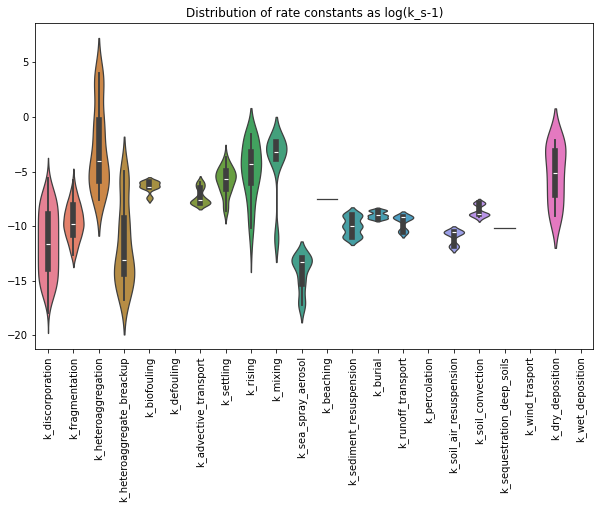

In [234]:

"""Estimate rate constants per particle"""

for particle in system_particle_object_list:
    generate_rateConstants(particle, spm, dict_comp, fsd, process_inputs_df)


## create rate constants table:
RC_df = create_rateConstants_table(system_particle_object_list)
df4 = RC_df.fillna(0)

# Plot rate constants (not implemented anymore)

"""(FIX RC for wet deposition, now its given as a list of rate constants per surface compartment only for dry deposition and wet depossition is turned off)This needs to be fixed also for the matrix of interactions and estimation of flows"""
rateConstants_df=df4
selected_columns = rateConstants_df.columns[3:]
data_raw=df4[selected_columns]
selected_data=data_raw.applymap(sum_if_list)
log_data = selected_data.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=log_data)
#plt.yscale('log')
plt.xticks(rotation=90)
plt.title("Distribution of rate constants as log(k_s-1)")
plt.show()


In [235]:

"""Build Matrix of interactions"""

interactions_df = fillInteractions_fun_OOP(
    system_particle_object_list, SpeciesList, surfComp_list
)


"""SOLVE SYSTEM OF ODES"""


R, PartMass_t0 = solve_ODES_SS(
    system_particle_object_list=system_particle_object_list,
    q_num_s=0,
    imput_flows_g_s=imput_flows_g_s,
    interactions_df=interactions_df,
)

# Reformat results (R) dataframe
R["Size_Fraction_um"] = [size_dict[x[0]] for x in R.index]
R["MP_Form"] = [MP_form_dict_reverse[x[1]] for x in R.index]
R["Compartment"] = [comp_dict_inverse[float(x[2:-7])] for x in R.index]

Results = R[
    [
        "Compartment",
        "MP_Form",
        "Size_Fraction_um",
        "mass_g",
        "number_of_particles",
        "concentration_g_m3",
        "concentration_num_m3",
    ]
]

# Solve mass balance and print result
massBalance(R, system_particle_object_list, q_mass_g_s)


# Test that there are no negative results
for i, idx in zip(R["mass_g"], R.index):
    if i < 0:
        print("negative values in the solution for " + idx)
    else:
        pass

# Estimate mass and number fractions and extract ranking tables of the species with higest fractions to understand the distribution of the particles in the system by mass and number of particles

Results_extended, mf_shorted, nf_shorted = estimate_fractions(Results)

# Organise results in dictionary for plotting

Results_comp_dict = extract_by_comp(
    Results_extended.reset_index(), particle_compartmentCoding
)
Results_comp_organiced = extract_by_aggSt(Results_comp_dict, particle_forms_coding)

# Mass distribution by compartment

results_by_comp = extract_results_by_compartment(Results_extended, dict_comp)


### MASS BALANCE PER COMPARTMENT###

# Estimate mass flows due to the different particle fate process (transfer between compartments, elimination and transformation processes)


# Estimate outflows in mass (g/s) amd number/second
(tables_outputFlows, tables_outputFlows_number) = estimate_outFlows(
    system_particle_object_list, dict_comp
)

# Estimate imput flows from transport from other compartments
(tables_inputFlows, tables_inputFlows_num) = estimate_inFlows(
    tables_outputFlows, tables_outputFlows_number, dict_comp, surfComp_list
)

# Create flow dictionaries

# Decode index in input and output flow tables
flows_dict_mass = generate_flows_dict(
    tables_outputFlows, tables_inputFlows, size_dict, MP_form_dict_reverse
)

flows_dict_num = generate_flows_dict(
    tables_outputFlows_number, tables_inputFlows_num, size_dict, MP_form_dict_reverse
)

## Compartment mass balance

comp_mass_balance = {}
for comp in list(dict_comp.keys()):
    comp_mass_balance[comp] = compartment_massBalance(
        comp=comp,
        tables_outputFlows=tables_outputFlows,
        PartMass_t0=PartMass_t0,
        comp_dict_inverse=comp_dict_inverse,
        dict_comp=dict_comp,
        tables_inputFlows=tables_inputFlows,
    )

# Print compartment mass balance table
comp_mass_balance_df = pd.DataFrame.from_dict(comp_mass_balance, orient="index")


comp_mass_balance_df["Mass balance"] = [
    comp_mass_balance_df["Inflow"][c] - comp_mass_balance_df["Outflow"][c]
    for c in comp_mass_balance_df.index
]


# Add total steady state mass and number of particles concentrations to dataframe


comp_mass_balance_df["Concentration (g/m3)"] = [
    sum(Results_comp_dict[c].concentration_g_m3) for c in comp_mass_balance_df.index
]
comp_mass_balance_df["Concentration (N/m3)"] = [
    sum(Results_comp_dict[c].concentration_num_m3) for c in comp_mass_balance_df.index
]

print(comp_mass_balance_df["Mass balance"])

Difference inflow-outflow = 7.350172381848097e-08
Ocean_Surface_Water        1.192093e-07
Ocean_Mixed_Water         -1.192093e-07
Ocean_Column_Water        -1.364242e-12
Coast_Surface_Water       -1.192093e-07
Coast_Column_Water         5.960464e-08
Surface_Freshwater        -9.094947e-13
Bulk_Freshwater           -9.094947e-13
Sediment_Freshwater       -2.220446e-16
Sediment_Ocean             0.000000e+00
Sediment_Coast             0.000000e+00
Beaches_Soil_Surface       9.094947e-13
Beaches_Deep_Soil         -4.547474e-13
Background_Soil_Surface    1.776357e-15
Background_Soil            0.000000e+00
Impacted_Soil_Surface     -8.881784e-16
Impacted_Soil              8.881784e-16
Air                       -1.776357e-15
Name: Mass balance, dtype: float64


In [184]:
for c,b in zip(comp_mass_balance_df.index,comp_mass_balance_df["Mass balance"]):
    if b > 1E-3:
        print ("The mass balance of {} is not withing the tolerance limints: mass balance = {}".format(c,round(b,2)))

### Mass and number distribution heatmaps

c:\Users\PradoDomercq\Documents\Python Scripts\UTOPIA_model\venv\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


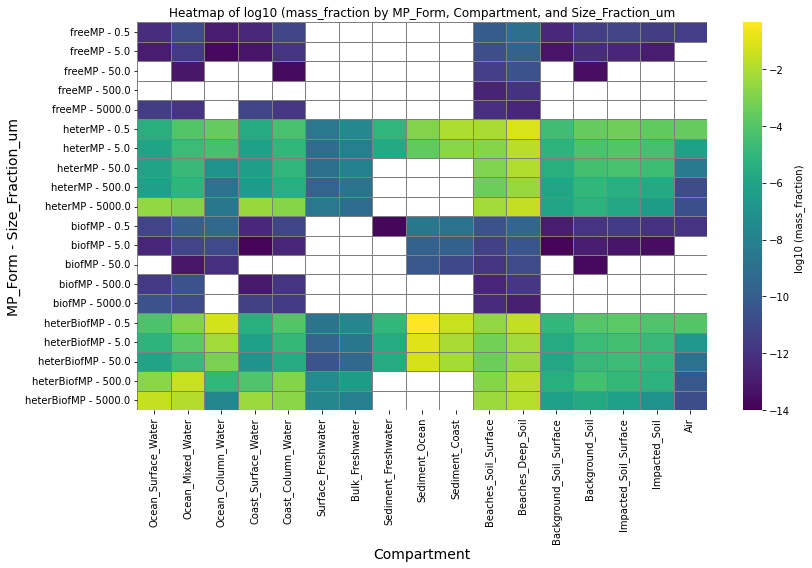

c:\Users\PradoDomercq\Documents\Python Scripts\UTOPIA_model\venv\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


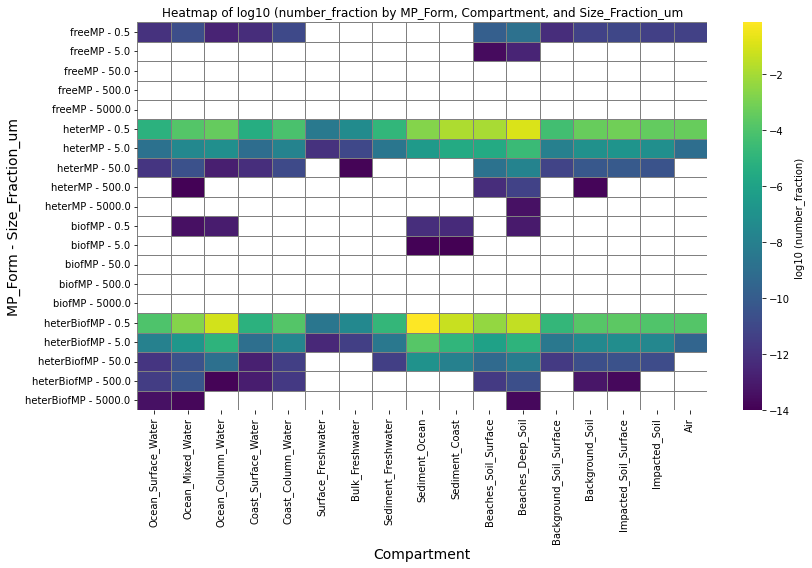

In [236]:

fig_mass, titlename_figmass = plot_fractionDistribution_heatmap(
    Results_extended, fraction="mass_fraction"
)
fig_num, titlename_fignum = plot_fractionDistribution_heatmap(
    Results_extended, fraction="number_fraction")

In [237]:
""" Add iput and output flows dict to results extended dataframe"""

Results_extended = addFlows_to_results_df(
    Results_extended, flows_dict_mass, flows_dict_num
)

#Correct input flows to include also the transformation processess (e.g.heteroaggregation)
# Only working for mass at the moment, need to estimate steady state particle numbers 

from functions.fillInteractions_dictionaries import*
#This is all in mass units
interactions_pp_df=fillInteractions_fun_OOP_dict(
    system_particle_object_list, SpeciesList, surfComp_list)

# Create a dictionary of recieving inflows per particle taking the values from the interactions matrix
particle_inflows_dict_mass={}
particle_inflows_dict_number={}
for p in system_particle_object_list:
    inflows_p_mass=[]
    #inflows_p_num=[]
    for p2 in system_particle_object_list:
        interaction_rate=interactions_pp_df[p2.Pcode][p.Pcode]
        if type(interaction_rate) == dict:
            inflow={k: v * p2.Pmass_g_SS for k, v in interaction_rate.items()}
            inflows_p_mass.append(inflow)
            #inflows_p_num.append({k: v * p2.Pnum_g_SS for k, v in interaction_rate.items()})
        else:
            inflows_p_mass.append(interaction_rate)
            #inflows_p_num.append(interaction_rate)
    dict_list=[item for item in inflows_p_mass if isinstance(item, dict)]
    #dict_list_num=[item for item in inflows_p_num if isinstance(item, dict)]
    merged_dict={}
    #merged_dict_num={}
    for d in dict_list:
        for k, v in d.items():
            if k in merged_dict:
                merged_dict[k] += v
                #merged_dict_num[k] += v
            else:
                merged_dict[k] = v
                #merged_dict_num[k] = v
    
    particle_inflows_dict_mass[p.Pcode]=merged_dict
    #particle_inflows_dict_number[p.Pcode]=merged_dict_num
    
#Substitute the inputflow values in the results_extended dataframe:

for ele in particle_inflows_dict_mass:
    Results_extended.at[ele, "inflows_g_s"] = particle_inflows_dict_mass[ele]
    #Results_extended.at[ele, "inflows_num_s"] = particle_inflows_dict_number[ele]

Results_extended["Total_inflows_g_s"] = [
    sum(Results_extended.iloc[i].inflows_g_s.values())
    for i in range(len(Results_extended))
]

Results_extended["Total_outflows_g_s"] = [
    sum(Results_extended.iloc[i].outflows_g_s.values())
    for i in range(len(Results_extended))
]

Results_extended["Total_inflows_num_s"] = [
    sum(Results_extended.iloc[i].inflows_num_s.values())
    for i in range(len(Results_extended))
]

Results_extended["Total_outflows_num_s"] = [
    sum(Results_extended.iloc[i].outflows_num_s.values())
    for i in range(len(Results_extended))
]

""" Add iput and output flows dict to compartment results dataframe (results_by_comp)"""
results_by_comp = addFlows_to_results_df_comp(results_by_comp, flows_dict_mass, flows_dict_num)



In [238]:
from functions.fillInteractions_dictionaries import*
#This is all in mass units
interactions_pp_df=fillInteractions_fun_OOP_dict(
    system_particle_object_list, SpeciesList, surfComp_list
)
# Create a dictionary of recieving inflows per particle taking the values from the interactions matrix
particle_inflows_dict={}
for p in system_particle_object_list:
    inflows_p=[]
    for p2 in system_particle_object_list:
        interaction_rate=interactions_pp_df[p2.Pcode][p.Pcode]
        if type(interaction_rate) == dict:
            inflow={k: v * p2.Pmass_g_SS for k, v in interaction_rate.items()}
            inflows_p.append(inflow)
        else:
            inflows_p.append(interaction_rate)
    dict_list=[item for item in inflows_p if isinstance(item, dict)]
    merged_dict={}
    for d in dict_list:
        for k, v in d.items():
            if k in merged_dict:
                merged_dict[k] += v
            else:
                merged_dict[k] = v
    
    particle_inflows_dict[p.Pcode]=merged_dict

### Results by compartment

 Mass and particle number distribution per compartment

In [239]:
results_by_comp[["Compartments","%_mass"]].round(2).sort_values(by="%_mass", ascending=False)

,Compartments,%_mass
8,Sediment_Ocean,59.13
11,Beaches_Deep_Soil,18.53
2,Ocean_Column_Water,5.61
9,Sediment_Coast,5.39
1,Ocean_Mixed_Water,4.34
0,Ocean_Surface_Water,3.11
10,Beaches_Soil_Surface,2.45
3,Coast_Surface_Water,0.77
4,Coast_Column_Water,0.46
14,Impacted_Soil_Surface,0.08


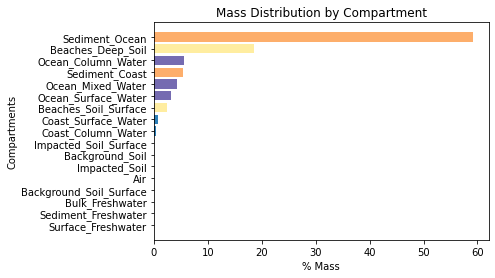

In [240]:
import matplotlib.pyplot as plt

# Assuming you have already defined your custom color mapping from earlier:
compartment_colors = {
    "Ocean_Surface_Water": '#756bb1', 
    "Ocean_Mixed_Water": '#756bb1', 
    "Ocean_Column_Water": '#756bb1', 
    "Coast_Surface_Water": '#2c7fb8', 
    "Coast_Column_Water": '#2c7fb8', 
    "Surface_Freshwater": '#9ebcda', 
    "Bulk_Freshwater": '#9ebcda', 
    "Sediment_Freshwater": '#fdae6b', 
    "Sediment_Ocean": '#fdae6b', 
    "Sediment_Coast": '#fdae6b', 
    "Beaches_Soil_Surface": '#ffeda0', 
    "Beaches_Deep_Soil": '#ffeda0', 
    "Background_Soil_Surface": '#e5f5e0', 
    "Background_Soil": '#e5f5e0', 
    "Impacted_Soil_Surface": '#d95f0e', 
    "Impacted_Soil": '#d95f0e', 
    "Air": '#deebf7'
}

# Add your dataframe sorting and rounding logic
df = results_by_comp[["Compartments", "%_mass"]].round(2).sort_values(by="%_mass", ascending=False)

# Get the list of colors based on the Compartments in the df
bar_colors = df["Compartments"].map(compartment_colors)

# Plot the horizontal bar chart
plt.barh(df["Compartments"], df["%_mass"], color=bar_colors)  # Apply specific colors to each bar
plt.xlabel('% Mass')
plt.ylabel('Compartments')
plt.title('Mass Distribution by Compartment')
plt.gca().invert_yaxis()  # Invert y-axis to match sorting order
plt.show()


In [241]:
results_by_comp[["Compartments","%_number"]].round(2).sort_values(by="%_number", ascending=False)

,Compartments,%_number
8,Sediment_Ocean,69.15
11,Beaches_Deep_Soil,14.99
2,Ocean_Column_Water,7.81
9,Sediment_Coast,6.04
10,Beaches_Soil_Surface,1.53
1,Ocean_Mixed_Water,0.20
14,Impacted_Soil_Surface,0.09
13,Background_Soil,0.06
16,Air,0.05
15,Impacted_Soil,0.04


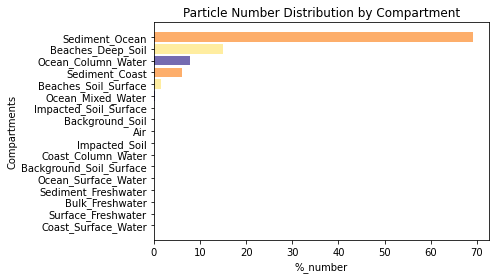

In [242]:
# Add your dataframe sorting and rounding logic
df = results_by_comp[["Compartments", "%_number"]].round(2).sort_values(by="%_number", ascending=False)

# Get the list of colors based on the Compartments in the df
bar_colors = df["Compartments"].map(compartment_colors)

# Plot the horizontal bar chart
plt.barh(df["Compartments"], df["%_number"], color=bar_colors)  # Apply specific colors to each bar
plt.xlabel('%_number')
plt.ylabel('Compartments')
plt.title('Particle Number Distribution by Compartment')
plt.gca().invert_yaxis()  # Invert y-axis to match sorting order
plt.show()

#### Size fraction distribution

In [243]:
## Mass and particle number distribution by size fraction
size_distr = [0.5, 5, 50, 500, 5000]
Pmass = []
Pnumber = []
for size in size_distr:
    Pmass.append(
        round(
            sum(
                Results_extended[Results_extended["Size_Fraction_um"] == size][
                    "mass_g"
                ]
            )
            / sum(Results_extended["mass_g"])
            * 100,
            2,
        )
    )
    Pnumber.append(
        round(
            sum(
                Results_extended[Results_extended["Size_Fraction_um"] == size][
                    "number_of_particles"
                ]
            )
            / sum(Results_extended["number_of_particles"])
            * 100,
            2,
        )
    )

size_distribution_df = pd.DataFrame(
    {
        "Size_Fraction_um": size_distr,
        "% of total mass": Pmass,
        "% of total particle number": Pnumber,
    }
)
size_distribution_df

,Size_Fraction_um,% of total mass,% of total particle number
0,0.5,63.29,99.98
1,5.0,13.07,0.02
2,50.0,8.32,0.00
3,500.0,5.21,0.00
4,5000.0,10.11,0.00


In [244]:
form_distr={}
for form in ["freeMP","heterMP", "biofMP", "heterBiofMP"]:
    form_distr[form]=round(sum(Results_extended[Results_extended["MP_Form"] == form]["number_of_particles"])/sum(Results_extended["number_of_particles"])*100,2)

pd.DataFrame.from_dict(form_distr, orient="index", columns=["% of total particle number"])

,% of total particle number
freeMP,0.00
heterMP,14.05
biofMP,0.00
heterBiofMP,85.95


### Exposure indicators

In [245]:
# For estimating exposure indicators we need to make emissions to targeted compartments.

# Run model with emissions to specific compartments to estimate the emission fractions
from functions.model_run_by_comp import *

model_results = {}
dispersing_comp_list = [
    "Air",
    "Ocean_Mixed_Water",
    "Ocean_Surface_Water",
]

for dispersing_comp in dispersing_comp_list:
    model_results[dispersing_comp] = run_model_comp(
        dispersing_comp,
        input_flow_g_s,
        interactions_df,
        MP_form,
        size_bin,
        particle_forms_coding,
        particle_compartmentCoding,
        system_particle_object_list,
        comp_dict_inverse,
        dict_comp,
        size_dict,
        MP_form_dict_reverse,
        surfComp_list,
    )



#### Emission fractions 

Environmentally Dispersed Mass Fractions through Air = 0.00011138787504496681
Environmentally Dispersed Mass Fractions through Ocean_Mixed_Water = 3.905110398927183e-05
Environmentally Dispersed Mass Fractions through Ocean_Surface_Water = 1.6797400304059254e-06
φ1 for mass = 0.00015211871906464455
Environmentally Dispersed Particle Number Fractions through Air = 111146868
Environmentally Dispersed Particle Number Fractions through Ocean_Mixed_Water = 1119157
Environmentally Dispersed Particle Number Fractions through Ocean_Surface_Water = 3360
φ1 for particle number = 112269386.14523083
Remotely transferred fraction to Ocean_Surface_Water = 0.00010367294403176119
Remotely transferred fraction to Ocean_Column_Water = 6.974967076479631e-11
Remotely transferred fraction to Sediment_Ocean = 2.2991337646832735e-10
Remotely transferred fraction to Beaches_Soil_Surface = 4.543579517490058e-07
Total remotely transferred mass fraction = 0.00010412760164655742


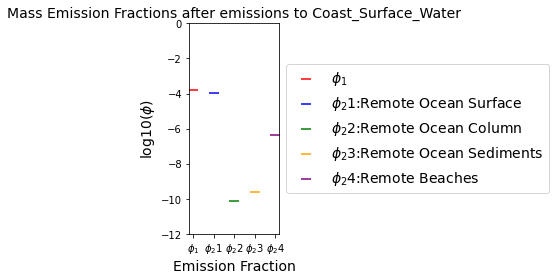

In [246]:


# Estimate emission fractions for the setted emission scenario

emission_fractions_mass_data = emission_fractions_calculations(
    Results_extended,
    model_results,
    dispersing_comp_list,
    dict_comp,
    input_flow_g_s,
    q_num_s,
    size_dict,
    emiss_comp,
)

emiss_fract_fig = plot_emission_fractions(emission_fractions_mass_data, emiss_comp)



#### Overall persistence and residence time in years

In [247]:

# Overall persistance (Pov) and Overall residence time (Tov) in years:
print_output="True"

(
    Pov_mass_years,
    Pov_num_years,
    Pov_size_dict_years,
    Tov_mass_years,
    Tov_num_years,
    Tov_size_dict_years,
    Pov_Tov_comp_df,
) = Exposure_indicators_calculation(
    tables_outputFlows,
    tables_outputFlows_number,
    Results_extended,
    size_dict,
    dict_comp,
    system_particle_object_list,
    print_output,
    imput_flows_g_s,
    tables_inputFlows_num,
)

""" Add persistence and residence time to results extended dataframe"""

Results_extended = calculate_persistence_residence_time(Results_extended)
Results_extended_comp = calculate_persistence_residence_time_comp(results_by_comp)

Pov_Tov_comp_df

Overall mass persistence (years): 1
Overall particle number persistence (years): 1037487816
Overall residence time is calculated assuming the model boundaries to be at 100 m depth into the Ocean, 30 cm into the sediments and 0.1 m into the soil. Particles travelling deeper are considered losses
Overall mass residence time (years): 1.2
Overall particle number residence time (years): 18.0
Overall residence time of size 0.5 um (years): 17.58
Overall residence time of size 5.0 um (years): 17.89
Overall residence time of size 50.0 um (years): 18.01
Overall residence time of size 500.0 um (years): 88.79
Overall residence time of size 5000.0 um (years): 0.35


,Compartment,Pov_years(mass),Pov_years(particle_number),Tov_years(mass_g),Tov_years(particle_number)
0,Ocean_Surface_Water,1.458739e-01,1.238648e+07,0.000011,0.000011
1,Ocean_Mixed_Water,4.589513e+00,1.301375e+08,0.000016,0.000229
2,Ocean_Column_Water,3.745734e+05,1.291816e+08,5.462340,7.009649
3,Coast_Surface_Water,1.715868e-01,1.384117e+07,0.000006,0.000006
4,Coast_Column_Water,2.394121e+00,1.524792e+08,0.000003,0.000115
5,Surface_Freshwater,3.637543e-01,1.804492e+07,0.000005,0.000005
6,Bulk_Freshwater,5.378577e+01,1.805448e+08,0.000030,0.000047
7,Sediment_Freshwater,1.343226e+06,1.658710e+09,8.569873,8.570464
8,Sediment_Ocean,1.247528e+06,1.277475e+09,62.157611,62.189113
9,Sediment_Coast,1.040843e+06,1.436937e+09,28.822399,28.830486


In [248]:

# Caracteristic travel distance (CDT) (m):

# To calculate CTD we need to estimate it by emitting into the especific mobile compartment. We will calculate CTD derived from emmiting to each compartment and taking the higest value:
CTD_mass_list = []
CTD_number_list = []


for CDT_comp in [
    "Ocean_Surface_Water",
    "Ocean_Mixed_Water",
    "Coast_Surface_Water",
    "Coast_Column_Water",
    "Surface_Freshwater",
    "Bulk_Freshwater",
    "Air",
]:
    # input flow (in g per second) for each compartment the User should specify here the input flows per compartment
    q_mass_g_s_dict_CTD = {
        "Ocean_Surface_Water": 0,
        "Ocean_Mixed_Water": 0,
        "Ocean_Column_Water": 0,
        "Coast_Surface_Water": 0,
        "Coast_Column_Water": 0,
        "Surface_Freshwater": 0,
        "Bulk_Freshwater": 0,
        "Sediment_Freshwater": 0,
        "Sediment_Ocean": 0,
        "Sediment_Coast": 0,
        "Beaches_Soil_Surface": 0,
        "Beaches_Deep_Soil": 0,
        "Background_Soil_Surface": 0,
        "Background_Soil": 0,
        "Impacted_Soil_Surface": 0,
        "Impacted_Soil": 0,
        "Air": 0,
    }
    q_mass_g_s_dict_CTD[CDT_comp] = input_flow_g_s

    sp_imputs_CTD = []
    q_mass_g_s_CTD = []
    for compartment in q_mass_g_s_dict_CTD.keys():
        sp_imputs_CTD.append(
            size_bin
            + particle_forms_coding[MP_form]
            + str(particle_compartmentCoding[compartment])
            + "_"
            + boxName
        )
        q_mass_g_s_CTD.append(q_mass_g_s_dict_CTD[compartment])

    imput_flows_g_s_CTD = dict(zip(sp_imputs_CTD, q_mass_g_s_CTD))

    CTD_km = model_run_CTD(
        system_particle_object_list,
        CDT_comp,
        imput_flows_g_s_CTD,
        interactions_df,
        q_mass_g_s_CTD,
        size_dict,
        MP_form_dict_reverse,
        comp_dict_inverse,
        dict_comp,
    )

    CTD_mass_list.append(CTD_km[0])
    CTD_number_list.append(CTD_km[1])

CTD_df = pd.DataFrame(
    index=[
        "Ocean_Surface_Water",
        "Ocean_Mixed_Water",
        "Coast_Surface_Water",
        "Coast_Column_Water",
        "Surface_Freshwater",
        "Bulk_Freshwater",
        "Air",
    ]
)

CTD_df["CTD_mass_km"] = CTD_mass_list
CTD_df["CTD_particle_number_km"] = CTD_number_list

print(
    "Characteristic mass travel distance (CDT): ",
    round(CTD_df["CTD_mass_km"].max(), 1),
    " km",
)

print(
    "Characteristic particle number travel distance (CDT): ",
    round(CTD_df["CTD_particle_number_km"].max(), 1),
    " km",
)


Characteristic mass travel distance (CDT):  19397.5  km
Characteristic particle number travel distance (CDT):  10946334328.4  km


### Extract input and output flows per compartment


In [249]:
results_comp_extended=add_output_flow_conexions(results_by_comp,dict_comp,outputflow_type="outflows_g_s",inputflow_type="inflows_g_s")
results_comp_extended=add_output_flow_conexions(results_by_comp,dict_comp,outputflow_type="outflows_num_s",inputflow_type="inflows_num_s")

In [250]:
results_comp_extended

,Compartments,mass_g,number_of_particles,%_mass,%_number,Concentration_g_m3,Concentration_num_m3,inflows_g_s,inflows_num_s,outflows_g_s,outflows_num_s,Residence_time_mass_years,Residence_time_num_years,Persistence_time_mass_years,Persistence_time_num_years,outflow_conexions_g_s,outflow_conexions_num_s
0,Ocean_Surface_Water,3.563524e+11,1.111364e+22,3.109278,9.825154e-03,2.186211e-04,6.818183e+06,"{'k_rising': 914874921.3236217, 'k_mixing': 68...","{'k_rising': 234094813955.91052, 'k_mixing': 3...","{'k_discorporation': 77463.23029347873, 'k_adv...","{'k_discorporation': 28451269.79237781, 'k_adv...",3.623122e+02,3.618523e+02,4.600278e+06,3.906201e+14,{'Ocean_Mixed_Water': {'settling': 3386.481617...,{'Ocean_Mixed_Water': {'settling': 3.908704771...
1,Ocean_Mixed_Water,4.975728e+11,2.223206e+23,4.341468,1.965454e-01,1.526297e-05,6.819651e+06,"{'k_settling': 3386.481617926898, 'k_mixing': ...","{'k_settling': 3.908704771506748e+16, 'k_mixin...","{'k_discorporation': 3437.8226793866447, 'k_ad...","{'k_discorporation': 54171470.124278314, 'k_ad...",5.058946e+02,7.236419e+03,1.447349e+08,4.104017e+15,{'Ocean_Surface_Water': {'rising': 914874921.3...,{'Ocean_Surface_Water': {'rising': 23409481395...
2,Ocean_Column_Water,6.427533e+11,8.831201e+24,5.608210,7.807336e+00,4.906514e-07,6.741375e+06,"{'k_settling': 3388.5321827500247, 'k_mixing':...","{'k_settling': 3.9097413759767176e+16, 'k_mixi...","{'k_discorporation': 0.05441276501991258, 'k_a...","{'k_discorporation': 2167765892.9707484, 'k_ad...",1.778594e+08,2.210404e+08,1.181255e+13,4.073872e+15,{'Ocean_Mixed_Water': {'rising': 152.344371474...,{'Ocean_Mixed_Water': {'rising': 1929727.27020...
3,Coast_Surface_Water,8.810022e+10,1.208372e+21,0.768700,1.068277e-03,1.312969e-03,1.800853e+07,"{'k_advective_transport': 14669.484146976549, ...","{'k_advective_transport': 457510300810252.94, ...","{'k_discorporation': 16281.202274584579, 'k_ad...","{'k_discorporation': 2768351.787014959, 'k_adv...",1.813955e+02,1.811910e+02,5.411162e+06,4.364953e+14,{'Ocean_Surface_Water': {'advective_transport'...,{'Ocean_Surface_Water': {'advective_transport'...
4,Coast_Column_Water,5.299012e+10,2.411758e+22,0.462354,2.132146e-02,3.954487e-05,1.799820e+07,"{'k_advective_transport': 6822.604367058817, '...","{'k_advective_transport': 3048485811207958.5, ...","{'k_discorporation': 701.8464914993544, 'k_adv...","{'k_discorporation': 5015528.592275604, 'k_adv...",1.091240e+02,3.614739e+03,7.550101e+07,4.808583e+15,{'Ocean_Mixed_Water': {'advective_transport': ...,{'Ocean_Mixed_Water': {'advective_transport': ...
5,Surface_Freshwater,6.914950e+05,7.816532e+17,0.000006,6.910305e-07,7.640828e-08,8.637052e+04,"{'k_rising': 1727.6771459269146, 'k_mixing': 2...","{'k_rising': 4321730.475246923, 'k_mixing': 52...","{'k_discorporation': 0.060280144218634715, 'k_...","{'k_discorporation': 1373.5756190861514, 'k_ad...",1.492215e+02,1.489264e+02,1.147136e+07,5.690645e+14,{'Coast_Surface_Water': {'advective_transport'...,{'Coast_Surface_Water': {'advective_transport'...
6,Bulk_Freshwater,4.336635e+06,7.821014e+18,0.000038,6.914267e-06,4.791862e-08,8.642005e+04,"{'k_settling': 0.991162901495129, 'k_mixing': ...","{'k_settling': 11501039870942.654, 'k_mixing':...","{'k_discorporation': 0.002556694817710569, 'k_...","{'k_discorporation': 1373.6352055463751, 'k_ad...",9.357746e+02,1.489237e+03,1.696188e+09,5.693662e+15,{'Coast_Column_Water': {'advective_transport':...,{'Coast_Column_Water': {'advective_transport':...
7,Sediment_Freshwater,2.686530e+08,3.110978e+21,0.002344,2.750300e-03,2.968542e-04,3.437545e+09,{'k_settling': 0.994022534183475},{'k_settling': 11510282984318.191},"{'k_discorporation': 6.342145439396521e-06, 'k...","{'k_discorporation': 59473.02127722343, 'k_sed...",2.702703e+08,2.702703e+08,4.235996e+13,5.230906e+16,{'Bulk_Freshwater': {'sediment_resuspension': ...,{'Bulk_Freshwater': {'sediment_resuspension': ...
8,Sediment_Ocean,6.776954e+12,7.821893e+25,59.130891,6.915045e+01,6.922322e-01,7.989677e+12,{

### Uncertainty and sensitivity analysis

In [251]:
import monaco as mc

# Import the statistical distributions from scipy.stats that you will be using.
# These must be rv_discrete or rv_continuous functions.
# See https://docs.scipy.org/doc/scipy/reference/stats.html for a complete list.
from scipy.stats import randint, rv_discrete, lognorm, uniform

add other inputs to add uncertainty to the fragmentation rates (i.e. heteroagg_frac_factor=100, biofouled_frag_factor=1/2)
include the explosiveness_index to the montecarlo simulation EI)
Degradation factors:
t_half_deg_free
heter_deg_rate
biof_deg_rate


In [252]:
# The preprocessing function should only take in an Case object, and extract the
# values from inside it in order to build the inputs for the run function.
def template_preprocess(case):
    
    # Variables that will be passed to the run function and will be sampled
    MPdensity = case.invals['MPdensity'].val
    t_frag_gen_FreeSurfaceWater = case.invals['t_frag_gen_FreeSurfaceWater'].val
    heter_frag_factor=case.invals['heter_frag_factor'].val
    biof_frag_factor=case.invals['biof_frag_factor'].val
    FI=case.invals['FI'].val
    t_half_deg_free=case.invals['t_half_deg_free'].val
    heter_deg_factor=case.invals['heter_deg_factor'].val
    biof_deg_factor=case.invals['biof_deg_factor'].val
    
    factor_deepWater_soilSurface=case.invals['factor_deepWater_soilSurface'].val
    factor_sediment=case.invals['factor_sediment'].val
    
    
    # Other fixed variables
    MP_inputs=case.constvals["MP_inputs"]
    emission_inputs=emission_inputs
    

    return (MPdensity,t_frag_gen_FreeSurfaceWater,heter_frag_factor,biof_frag_factor,FI,MP_inputs,emission_inputs,t_half_deg_free,heter_deg_factor,biof_deg_factor,factor_deepWater_soilSurface,factor_sediment
    )


In [253]:

# The run function input arguments need to match up with the outputs in the unpacked
# tuple from your preprocessing function
def UTOPIA_model_run(MPdensity,t_frag_gen_FreeSurfaceWater,heter_frag_factor,biof_frag_factor,FI,MP_inputs,emission_inputs,t_half_deg_free,heter_deg_factor,biof_deg_factor,factor_deepWater_soilSurface,factor_sediment):
    # write microplastics inputs file
    mp_imputFile_name = write_MPinputs_table(
    MPdensity,
    big_bin_diameter_um=MP_inputs["big_bin_diameter_um"],
    MP_composition=MP_inputs["MP_composition"],
    shape=MP_inputs["shape"],
    N_sizeBins=MP_inputs["N_sizeBins"],
    runName=MP_inputs["runName"],
    inputs_path=MP_inputs["inputs_path"]) 
    
    # generate model objects
    (system_particle_object_list,
    SpeciesList,
    spm,
    dict_comp,
    model_lists,
    particles_df) = generate_objects(
    inputs_path,
    boxName=boxName,
    MPforms_list=MPforms_list,
    comp_impFile_name=comp_impFile_name,
    comp_interactFile_name=comp_interactFile_name,
    mp_imputFile_name=mp_imputFile_name,
    spm_radius_um=spm_radius_um,
    spm_density_kg_m3=spm_density_kg_m3,
)
    
    # Estimate rate constants per particle
    
    # define degradation rates
    t_half_deg_heter=t_half_deg_free*heter_deg_factor
    t_half_deg_biof=t_half_deg_free*biof_deg_factor
    t_half_deg_biofHeter=t_half_deg_free*biof_deg_factor*heter_deg_factor
    
    
    thalf_deg_d_dict = {
     "freeMP": t_half_deg_free,
     "heterMP": t_half_deg_heter,
     "biofMP": t_half_deg_biof,
     "heterBiofMP": t_half_deg_biofHeter} 
    
    
    process_inputs_df = create_inputsTable_UTOPIA(
    inputs_path,
    model_lists,
    thalf_deg_d_dict,
    alpha_hetr_dict,
    t_frag_gen_FreeSurfaceWater,
    biof_frag_factor,
    heter_frag_factor,
    factor_deepWater_soilSurface,
    factor_sediment,
    save_op="notSave")
  

    # Generate fsd based on explosivity index (EI)
    fsd=generate_fsd_matrix(FI)
    
    for particle in system_particle_object_list:
        generate_rateConstants(particle, spm, dict_comp, fsd,process_inputs_df)


    # Build Matrix of interactions

    interactions_df = fillInteractions_fun_OOP(
        system_particle_object_list, SpeciesList, surfComp_list
    )

    # SOLVE SYSTEM OF ODES
    
    imput_flows_g_s =emission_inputs["imput_flows_g_s"]


    R, PartMass_t0 = solve_ODES_SS(
        system_particle_object_list=system_particle_object_list,
        q_num_s=0,
        imput_flows_g_s=imput_flows_g_s,
        interactions_df=interactions_df,
    )

    # Reformat results (R) dataframe
    R["Size_Fraction_um"] = [size_dict[x[0]] for x in R.index]
    R["MP_Form"] = [MP_form_dict_reverse[x[1]] for x in R.index]
    R["Compartment"] = [comp_dict_inverse[float(x[2:-7])] for x in R.index]

    Results = R[
        [
            "Compartment",
            "MP_Form",
            "Size_Fraction_um",
            "mass_g",
            "number_of_particles",
            "concentration_g_m3",
            "concentration_num_m3",
        ]
    ]

    Results_extended, mf_shorted, nf_shorted = estimate_fractions(Results)
    
    # All results by compartment
    results_by_comp=extract_results_by_compartment(Results_extended,dict_comp)

    # Estimate mass flows due to the different particle fate process (transfer between compartments, elimination and transformation processes)

    # Estimate outflows in mass (g/s) amd number/second
    (tables_outputFlows, tables_outputFlows_number) = estimate_outFlows(
        system_particle_object_list, dict_comp
    )


    # Estimate imput flows from transport from other compartments
    (tables_inputFlows, tables_inputFlows_num) = estimate_inFlows(
        tables_outputFlows, tables_outputFlows_number, dict_comp, surfComp_list
    )

    #  Calculate Exposure Indicators
    
    # Overall persistance (Pov) and Overall residence time (Tov) in years:
    print_output=False
    (
    Pov_mass_years,
    Pov_num_years,
    Pov_size_dict_years,
    Tov_mass_years,
    Tov_num_years,
    Tov_size_dict_years,
    Pov_Tov_comp_df,
) = Exposure_indicators_calculation(
    tables_outputFlows,
    tables_outputFlows_number,
    Results_extended,
    size_dict,
    dict_comp,
    system_particle_object_list,
    print_output,
    imput_flows_g_s,
    tables_inputFlows_num,
)
    # simulation_output=pd.DataFrame({'Pov_mass_years': [Pov_mass_years],
    #                      "Pov_num_years": [Pov_num_years],
    #                      "Tov_mass_years": [Tov_mass_years],
    #                      "Tov_num_years": [Tov_num_years],
    #                      })

    # Caracteristic travel distance (CDT) (m):

    # To calculate CTD we need to estimate it by emitting into the especific mobile compartment. We will calculate CTD derived from emmiting to each compartment and taking the higest value:
    CTD_mass_list = []
    CTD_number_list = []


    for CDT_comp in [
        "Ocean_Surface_Water",
        "Ocean_Mixed_Water",
        "Coast_Surface_Water",
        "Coast_Column_Water",
        "Surface_Freshwater",
        "Bulk_Freshwater",
        "Air",
    ]:
        # input flow (in g per second) for each compartment the User should specify here the input flows per compartment
        q_mass_g_s_dict_CTD = {
            "Ocean_Surface_Water": 0,
            "Ocean_Mixed_Water": 0,
            "Ocean_Column_Water": 0,
            "Coast_Surface_Water": 0,
            "Coast_Column_Water": 0,
            "Surface_Freshwater": 0,
            "Bulk_Freshwater": 0,
            "Sediment_Freshwater": 0,
            "Sediment_Ocean": 0,
            "Sediment_Coast": 0,
            "Beaches_Soil_Surface": 0,
            "Beaches_Deep_Soil": 0,
            "Background_Soil_Surface": 0,
            "Background_Soil": 0,
            "Impacted_Soil_Surface": 0,
            "Impacted_Soil": 0,
            "Air": 0,
        }
        q_mass_g_s_dict_CTD[CDT_comp] = input_flow_g_s

        sp_imputs_CTD = []
        q_mass_g_s_CTD = []
        for compartment in q_mass_g_s_dict_CTD.keys():
            sp_imputs_CTD.append(
                size_bin
                + particle_forms_coding[MP_form]
                + str(particle_compartmentCoding[compartment])
                + "_"
                + boxName
            )
            q_mass_g_s_CTD.append(q_mass_g_s_dict_CTD[compartment])

        imput_flows_g_s_CTD = dict(zip(sp_imputs_CTD, q_mass_g_s_CTD))

        CTD_km = model_run_CTD(
            system_particle_object_list,
            CDT_comp,
            imput_flows_g_s_CTD,
            interactions_df,
            q_mass_g_s_CTD,
            size_dict,
            MP_form_dict_reverse,
            comp_dict_inverse,
            dict_comp,
        )

        CTD_mass_list.append(CTD_km[0])
        CTD_number_list.append(CTD_km[1])

    CTD_df = pd.DataFrame(
        index=[
            "Ocean_Surface_Water",
            "Ocean_Mixed_Water",
            "Coast_Surface_Water",
            "Coast_Column_Water",
            "Surface_Freshwater",
            "Bulk_Freshwater",
            "Air",
        ]
    )

    CTD_df["CTD_mass_km"] = CTD_mass_list
    CTD_df["CTD_particle_number_km"] = CTD_number_list
    
    CTD=round(CTD_df["CTD_mass_km"].max(), 1)
    
    
    return Pov_mass_years,Pov_num_years,Tov_mass_years,Tov_num_years, CTD, results_by_comp


In [254]:
# For your postprocessing function, the first argument must be the case, and
# all input arguments after case need to match up with the outputs in the unpacked
# tuple from your run function.
def template_postprocess(case, Pov_mass_years,Pov_num_years,Tov_mass_years,Tov_num_years,CTD,results_by_comp):

    # Simulation outputs may be huge, and this is where postprocessing can be
    # done to extract the information you want. For example, you may only want
    # to know the last point in a timeseries.


    # It is good practice to provide a dictionary to map any non-number values
    # to numbers via a known valmap. If needed this will be auto-generated, but
    # manually assigning numbers will give greater control over plotting.
    #valmap = {'heads': 0, 'tails': 1}

    # Add output values from this case's simulation results, case information,
    # or from other data processing that you do in this file.
    # The name supplied here will become the outvar's name.
    case.addOutVal(name='Overall_Persistance_mass_years', val=Pov_mass_years)
    case.addOutVal(name='Overall_Persistance_num_years', val=Pov_num_years)
    case.addOutVal(name="Overall_Residence_time_mass_years", val=Tov_mass_years)
    case.addOutVal(name="Overall_Residence_time_num_years", val=Tov_num_years)
    case.addOutVal(name='CTD_mass_km', val=CTD)
    case.addOutVal(name='PEC_Ocean_Surface_Water_g_m3', val=results_by_comp.iloc[0].Concentration_g_m3)
       
    

In [255]:
# These get packaged in the following format for Sim to consume:
fcns = {'preprocess' : template_preprocess,
        'run'        : UTOPIA_model_run,
        'postprocess': template_postprocess}

# Set the number of random draws you wish to make.
# If firstcaseismedian is True, then case 0 will be run with the expected value of
# each statistical distribution as a 'nominal' run. The total number of cases
# will then be ndraws+1
ndraws = 10
firstcaseismedian = False

# Setting a known random seed is recommended for repeatability of random draws.
seed = 12362398

# Whether to run the simulation in a single thread. If True then the simulation
# will run single-threaded in a 'for' loop, and if False then the dask parallel 
# processing module will be used for running concurrent threads. The overhead of 
# dask may make it slower than single-threaded execution for runs that execute 
# quickly.
singlethreaded = True

# If you want, you can save all the results from each case to file, or just the
# postprocessed simulation results. This can be incredibly useful for examining
# time-consuming sim data after the fact without having to rerun the whole thing.
# On the other hand, if your run function generates a lot of data, you may not have
# enough storage space to save all of the raw case data. Plus, the file I/O may
# be the limiting factor that slows down your simulation. Try setting these flags
# to False and seeing how much faster the sim runs.
savecasedata = False
savesimdata = False

In [256]:
def calc_mu(mean_val,std_dev):
    return np.log(mean_val) - (std_dev**2) / 2

In [258]:

def UTOPIA_montecarlo_sim():
    # We first initialize the sim with a name of our choosing
    sim = mc.Sim(name='UTOPIA_run', ndraws=ndraws, fcns=fcns,
                firstcaseismedian=firstcaseismedian, seed=seed,
                singlethreaded=singlethreaded,
                savecasedata=savecasedata, savesimdata=savesimdata,
                verbose=True, debug=False)
    # Assuming a standard deviation (sigma) for the underlying normal distribution
    sigma = 0.05
    sigma2=0.05
    sigma_deg=0.05

    # Calculate mu
    mu = np.log(MPdensity_kg_m3) - (sigma**2) / 2
    mu2=np.log(t_frag_gen_FreeSurfaceWater) - (sigma2**2) / 2
    

    sim.addInVar(name='MPdensity', dist=lognorm, distkwargs={'s': sigma,'scale': np.exp(mu) })
    
    sim.addInVar(name="t_frag_gen_FreeSurfaceWater", dist=lognorm, distkwargs={'s': sigma2,'scale': np.exp(mu2)})
    
    sim.addInVar(name="FI", dist=uniform, distkwargs={'loc': 0.0, 'scale': 1.0})
    
    sim.addInVar(name="biof_frag_factor", dist=lognorm, distkwargs={'s': sigma_deg,'scale': np.exp(calc_mu(biof_frag_factor,sigma_deg))})
    
    sim.addInVar(name="heter_frag_factor", dist=lognorm, distkwargs={'s': sigma_deg,'scale': np.exp(calc_mu(heter_frag_factor,sigma_deg))})
    
    sim.addInVar(name="factor_deepWater_soilSurface", dist=lognorm, distkwargs={'s': sigma_deg,'scale': np.exp(calc_mu(factor_deepWater_soilSurface,sigma_deg))})
    
    sim.addInVar(name="factor_sediment", dist=lognorm, distkwargs={'s': sigma_deg,'scale': np.exp(calc_mu(factor_sediment,sigma_deg))})
    
    sim.addInVar(name="t_half_deg_free", dist=lognorm, distkwargs={'s': sigma_deg,'scale': np.exp(calc_mu(t_half_deg_free,sigma_deg))})
    
    sim.addInVar(name="heter_deg_factor",dist=lognorm, distkwargs={'s': sigma_deg,'scale': np.exp(calc_mu(heter_deg_factor,sigma_deg))})
    
    sim.addInVar(name="biof_deg_factor", dist=lognorm, distkwargs={'s': sigma_deg,'scale': np.exp(calc_mu(biof_deg_factor,sigma_deg))})
    
    # sim.addInVar(name="alpha_heter_free", dist=lognorm, distkwargs={'s': sigma_deg,'scale': np.exp(calc_mu(alpha_heter_free,sigma_deg))})
    
    # sim.addInVar(name="alpha_heter_biof", dist=lognorm, distkwargs={'s': sigma_deg,'scale': np.exp(calc_mu(alpha_heter_biof,sigma_deg))})
    
    sim.addConstVal(name="MP_inputs", val=MP_inputs)
    sim.addConstVal(name="emission_inputs", val=emission_inputs)
    sim.runSim()
    return sim

sim = UTOPIA_montecarlo_sim()

Running 'UTOPIA_run' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 10 input variables via the 'sobol_random' method... Done
Generating cases... Done


Preprocessing cases:   0%|          | 0/10 [00:00<?, ? cases/s]UserWarning: 
Preprocessing case 0 failed
Preprocessing case 1 failed
Preprocessing case 2 failed
Preprocessing case 3 failed
Preprocessing case 4 failed
Preprocessing case 5 failed
Preprocessing case 6 failed
Preprocessing case 7 failed
Preprocessing case 8 failed
Preprocessing case 9 failed
Running cases: 100%|██████████| 10/10 [00:00<00:00, 351.38 cases/s]



Running case 0 failed

Running case 1 failed

Running case 2 failed

Running case 3 failed

Running case 4 failed

Running case 5 failed

Running case 6 failed

Running case 7 failed

Running case 8 failed

Running case 9 failed


Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 308.78 cases/s]


Postprocessing case 0 failed

Postprocessing case 1 failed

Postprocessing case 2 failed

Postprocessing case 3 failed

Postprocessing case 4 failed

Postprocessing case 5 failed

Postprocessing case 6 failed

Postprocessing case 7 failed

Postprocessing case 8 failed

Postprocessing case 9 failed
Simulation complete! Runtime: 0:00:00.117047


Calculating sensitivity indices for 'Overall_Residence_time_mass_years'...
Calculating optimal hyperparameters Φ for 'Overall_Residence_time_mass_years' covariances...
L = 183.2427, Φ = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
L = 183.2427, Φ = [1.00000001 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
L = 183.2427, Φ = [1.         1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.        ]
L = 183.2427, Φ = [1.         1.         1.00000001 1.         1.         1.
 1.         1.         1.         1.        ]
L = 183.2427, Φ = [1.         1.         1.         1.00000001 1.         1.
 1.         1.         1.         1.        ]
L = 183.2427, Φ = [1.         1.         1.         1.         1.00000001 1.
 1.         1.         1.         1.        ]
L = 183.2427, Φ = [1.         1.         1.         1.         1.         1.00000001
 1.         1.         1.         1.        ]
L = 183.2427, Φ = [1.         1.    

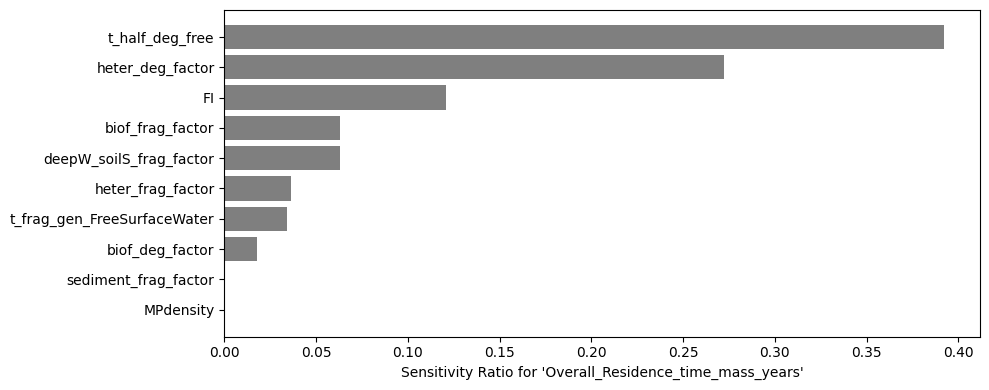

In [ ]:
## Calculate and plot sensitivity indices
sim.calcSensitivities(outvarnames="Overall_Residence_time_mass_years",tol=1e-6,verbose=True)
fig, ax = sim.outvars['Overall_Residence_time_mass_years'].plotSensitivities()
fig.set_size_inches(10, 4)
#plt.savefig('Overall Residence time (mass) sensitivities.png', dpi=100)
plt.show()

Calculating sensitivity indices for 'Overall_Persistance_mass_years'...
Calculating optimal hyperparameters Φ for 'Overall_Persistance_mass_years' covariances...
L = 976.9709, Φ = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
L = 976.9709, Φ = [1.00000001 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
L = 976.9709, Φ = [1.         1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.        ]
L = 976.9709, Φ = [1.         1.         1.00000001 1.         1.         1.
 1.         1.         1.         1.        ]
L = 976.9709, Φ = [1.         1.         1.         1.00000001 1.         1.
 1.         1.         1.         1.        ]
L = 976.9709, Φ = [1.         1.         1.         1.         1.00000001 1.
 1.         1.         1.         1.        ]
L = 976.9709, Φ = [1.         1.         1.         1.         1.         1.00000001
 1.         1.         1.         1.        ]
L = 976.9709, Φ = [1.         1.         1

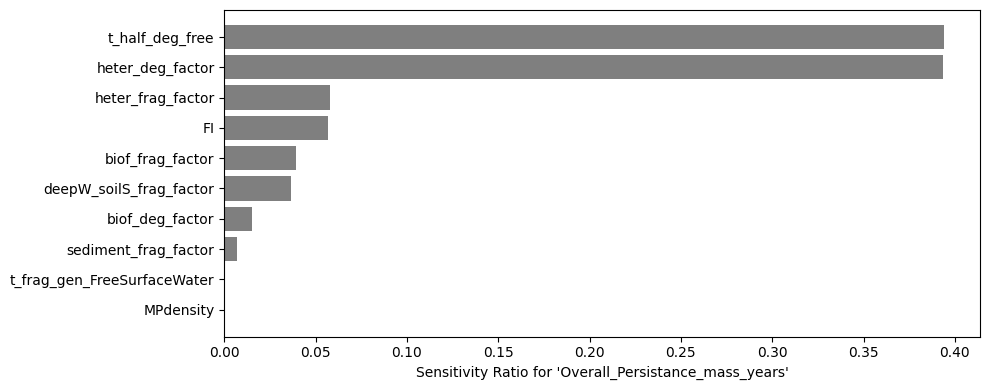

In [ ]:
## Calculate and plot sensitivity indices
sim.calcSensitivities(outvarnames="Overall_Persistance_mass_years",tol=1e-6,verbose=True)
fig, ax = sim.outvars['Overall_Persistance_mass_years'].plotSensitivities()
fig.set_size_inches(10, 4)
#plt.savefig('Overall_Persistance_mass_sensitivities.png', dpi=100)
plt.show()


(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='MPdensity'>,
  <Axes: ylabel='Overall_Persistance_mass_years'>,
  <Axes: >))

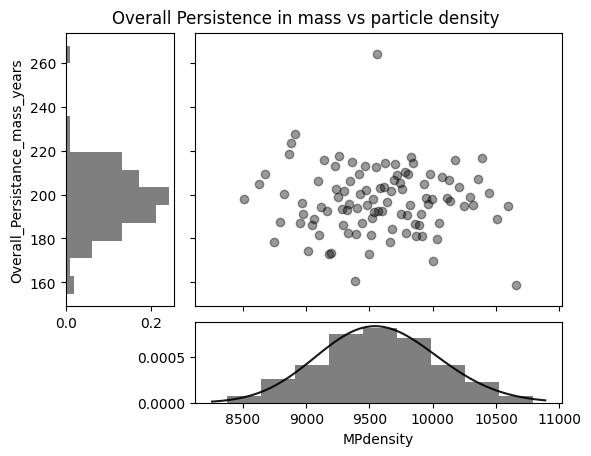

In [ ]:
mc.multi_plot([sim.invars["MPdensity"],sim.outvars["Overall_Persistance_mass_years"]],title="Overall Persistence in mass vs particle density",cov_plot=False)

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='heter_deg_factor'>,
  <Axes: ylabel='Overall_Persistance_num_years'>,
  <Axes: >))

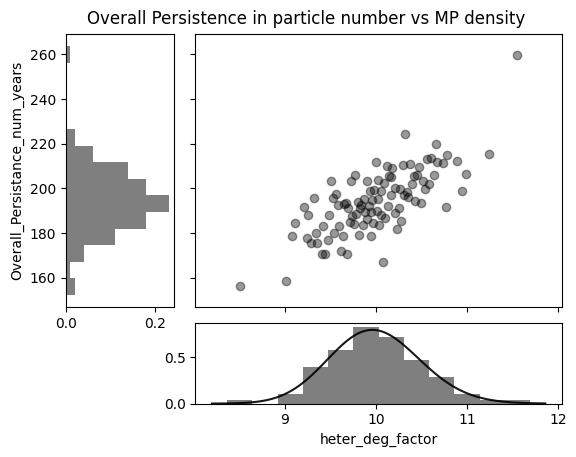

In [ ]:
mc.multi_plot([sim.invars["heter_deg_factor"],sim.outvars["Overall_Persistance_num_years"]],title="Overall Persistence in particle number vs MP density",cov_plot=False)

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='t_frag_gen_FreeSurfaceWater'>,
  <Axes: ylabel='Overall_Persistance_mass_years'>,
  <Axes: >))

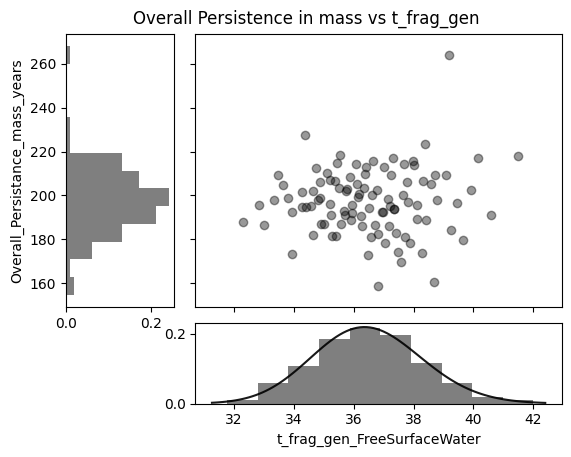

In [ ]:
mc.multi_plot([sim.invars["t_frag_gen_FreeSurfaceWater"],sim.outvars["Overall_Persistance_mass_years"]],title="Overall Persistence in mass vs t_frag_gen",cov_plot=False)

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='t_frag_gen_FreeSurfaceWater'>,
  <Axes: ylabel='Overall_Persistance_num_years'>,
  <Axes: >))

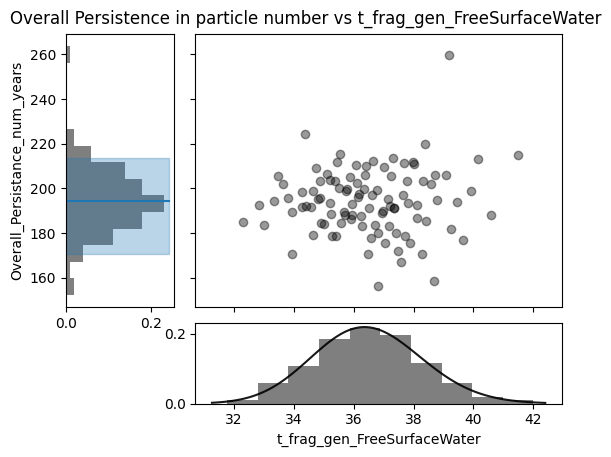

In [ ]:
sim.outvars['Overall_Persistance_num_years'].addVarStat('mean')
sim.outvars['Overall_Persistance_num_years'].addVarStat('percentile',
{'p':[0.05, 0.95]})
mc.multi_plot([sim.invars["t_frag_gen_FreeSurfaceWater"],sim.outvars["Overall_Persistance_num_years"]],title="Overall Persistence in particle number vs t_frag_gen_FreeSurfaceWater",cov_plot=False)

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='FI'>,
  <Axes: ylabel='Overall_Persistance_num_years'>,
  <Axes: >))

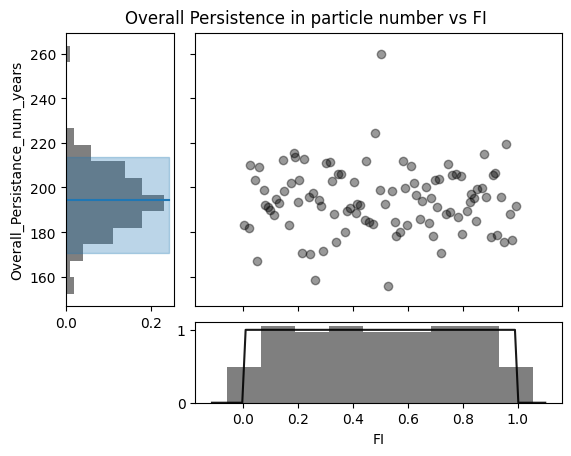

In [ ]:
mc.multi_plot([sim.invars["FI"],sim.outvars["Overall_Persistance_num_years"]],title="Overall Persistence in particle number vs FI",cov_plot=False)

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='FI'>,
  <Axes: ylabel='Overall_Persistance_mass_years'>,
  <Axes: >))

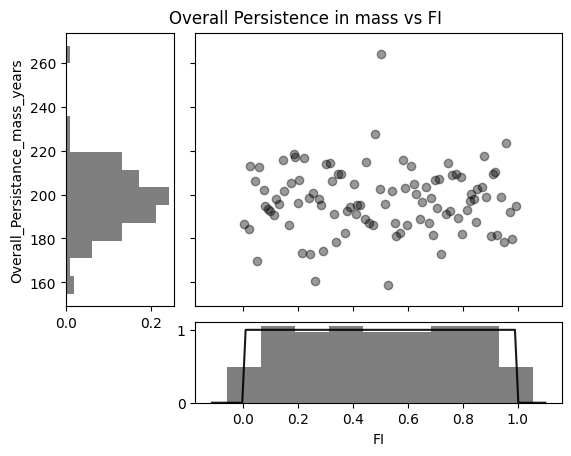

In [ ]:
mc.multi_plot([sim.invars["FI"],sim.outvars["Overall_Persistance_mass_years"]],title="Overall Persistence in mass vs FI",cov_plot=False)

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='FI'>,
  <Axes: ylabel='Overall_Residence_time_mass_years'>,
  <Axes: >))

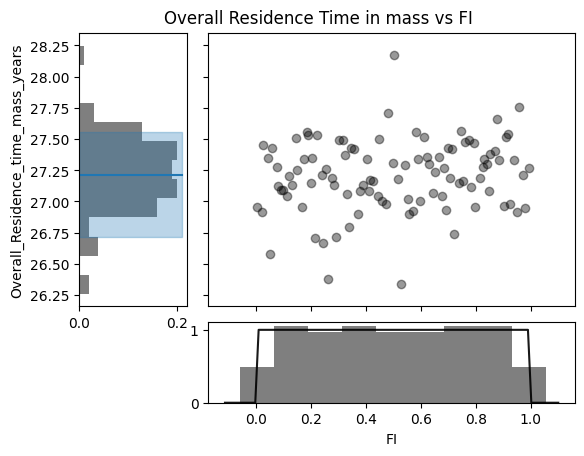

In [ ]:
sim.outvars['Overall_Residence_time_mass_years'].addVarStat('mean')
sim.outvars['Overall_Residence_time_mass_years'].addVarStat('percentile',
{'p':[0.05, 0.95]})
mc.multi_plot([sim.invars["FI"],sim.outvars["Overall_Residence_time_mass_years"]],title="Overall Residence Time in mass vs FI",cov_plot=False)

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='t_frag_gen_FreeSurfaceWater'>,
  <Axes: ylabel='Overall_Residence_time_num_years'>,
  <Axes: >))

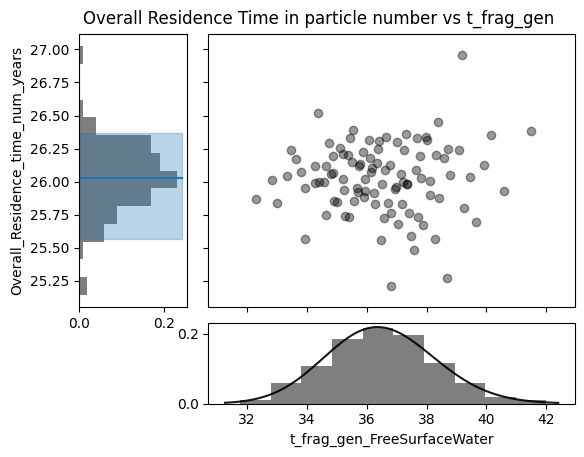

In [ ]:
sim.outvars['Overall_Residence_time_num_years'].addVarStat('mean')
sim.outvars['Overall_Residence_time_num_years'].addVarStat('percentile',
{'p':[0.05, 0.95]})
mc.multi_plot([sim.invars["t_frag_gen_FreeSurfaceWater"],sim.outvars["Overall_Residence_time_num_years"]],title="Overall Residence Time in particle number vs t_frag_gen",cov_plot=False)

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='FI'>,
  <Axes: ylabel='Overall_Residence_time_mass_years'>,
  <Axes: >))

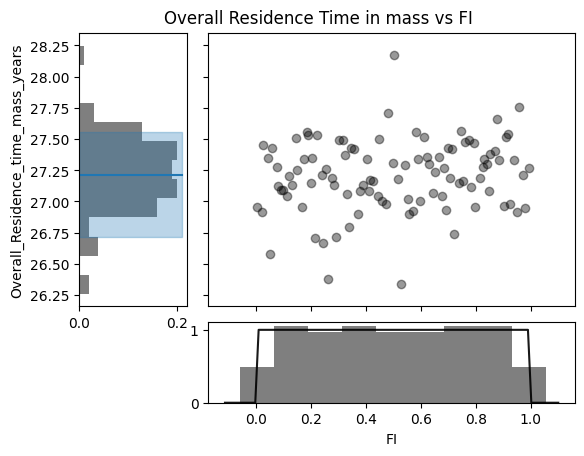

In [ ]:
mc.multi_plot([sim.invars["FI"],sim.outvars["Overall_Residence_time_mass_years"]],title="Overall Residence Time in mass vs FI",cov_plot=False)

Calculating sensitivity indices for 'Overall_Persistance_num_years'...
Calculating optimal hyperparameters Φ for 'Overall_Persistance_num_years' covariances...
L = 1151.9115, Φ = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
L = 1151.9115, Φ = [1.00000001 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
L = 1151.9115, Φ = [1.         1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.        ]
L = 1151.9115, Φ = [1.         1.         1.00000001 1.         1.         1.
 1.         1.         1.         1.        ]
L = 1151.9115, Φ = [1.         1.         1.         1.00000001 1.         1.
 1.         1.         1.         1.        ]
L = 1151.9115, Φ = [1.         1.         1.         1.         1.00000001 1.
 1.         1.         1.         1.        ]
L = 1151.9115, Φ = [1.         1.         1.         1.         1.         1.00000001
 1.         1.         1.         1.        ]
L = 1151.9115, Φ = [1.         1.    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


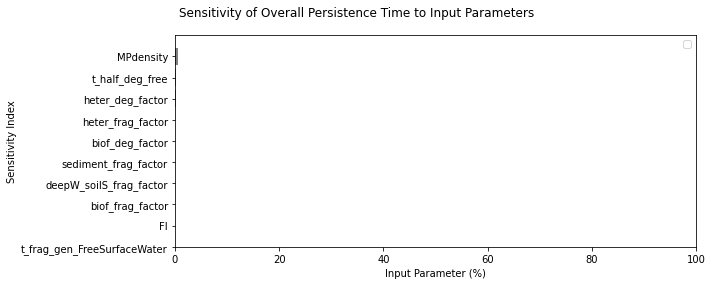

In [ ]:
sim.calcSensitivities(outvarnames="Overall_Persistance_num_years",tol=1e-6,verbose=True)
fig, ax = sim.outvars['Overall_Persistance_num_years'].plotSensitivities()
fig.set_size_inches(10, 4)
fig.suptitle('Sensitivity of Overall Persistence Time to Input Parameters')
ax.set_xlabel('Input Parameter (%)')
ax.set_ylabel('Sensitivity Index')
ax.invert_xaxis()
ax.set_xlim(0, 100)
ax.set_ylim(0, 10)  # adjust the y-axis limits as needed
ax.legend()
plt.savefig('Overall_Persistence_time_num_sensitivities.png', dpi=300)
plt.show()

Calculating sensitivity indices for 'Overall_Persistance_num_years'...
Calculating optimal hyperparameters Φ for 'Overall_Persistance_num_years' covariances...
L = 1151.9115, Φ = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
L = 1151.9115, Φ = [1.00000001 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
L = 1151.9115, Φ = [1.         1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.        ]
L = 1151.9115, Φ = [1.         1.         1.00000001 1.         1.         1.
 1.         1.         1.         1.        ]
L = 1151.9115, Φ = [1.         1.         1.         1.00000001 1.         1.
 1.         1.         1.         1.        ]
L = 1151.9115, Φ = [1.         1.         1.         1.         1.00000001 1.
 1.         1.         1.         1.        ]
L = 1151.9115, Φ = [1.         1.         1.         1.         1.         1.00000001
 1.         1.         1.         1.        ]
L = 1151.9115, Φ = [1.         1.    

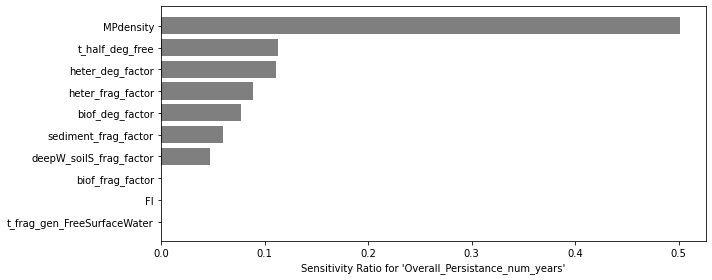

In [ ]:
## Calculate and plot sensitivity indices
sim.calcSensitivities(outvarnames="Overall_Persistance_num_years",tol=1e-6,verbose=True)
fig, ax = sim.outvars['Overall_Persistance_num_years'].plotSensitivities()
fig.set_size_inches(10, 4)
plt.savefig('Overall_Persistence_time_num_sensitivities.png', dpi=100)
plt.show()

(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Overall_Persistance_num_years', ylabel='Cumulative Probability'>)

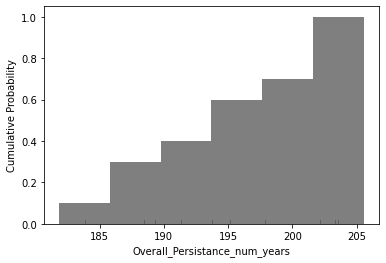

In [ ]:

mc.mc_plot.plot_cdf(sim.outvars["Overall_Persistance_num_years"])

(<Figure size 432x288 with 1 Axes>, <Axes: >)

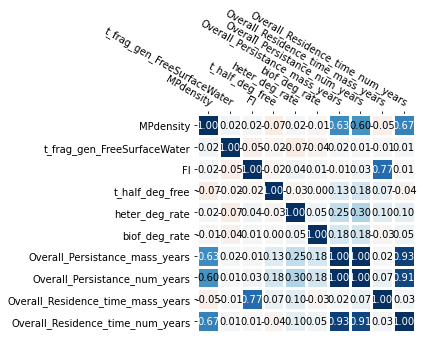

In [ ]:
mc.plot_cov_corr(*sim.corr())
